## 랜덤 포레스트(Random Forest) 구현하기

이번 수업에서는 머신러닝 알고리즘 중 하나인 랜덤 포레스트(이하 Random Forest)의 원리를 이해하고 이를 구현하겠습니다.

Random Forest는 Decision Tree에 앙상블(Ensemble) 방식중 하나인 배깅(Bagging, 내지는 Bootstrap aggregating)을 적용한 머신러닝 알고리즘입니다. 세부적으로는 다음과 같이 동작합니다.

1. 전체 데이터셋에서 랜덤하게 일부분을 떼냅니다.
2. 1번에서 떼낸 데이터로 Decision Tree를 만듭니다.
3. 1-2번 방식을 반복하면 이론적으로 무제한의 Decision Tree를 만들어낼 수 있습니다.
4. 이 방식을 통해 가능한 많은 Decision Tree를 만든 뒤, 이 Decision Tree끼리 투표(voting)를 합니다. (=평균을 냅니다.)

이 방식을 사용하면 거의 언제나 Decision Tree보다 좋은 성능을 내는 알고리즘이 나온다고 가정합니다. 


![Random Forest](https://www.researchgate.net/profile/Anwar_Isied/publication/282294180/figure/fig10/AS:283113084211213@1444510827643/Random-Forest.png)

이전에 Decision Tree와 마찬가지로, 이번에도 주어진 데이터와 문제를 Random Forest를 활용하여 풀되, [scikit-learn](http://scikit-learn.org/)과 같은 패키지를 사용하지 않고 파이썬으로 직접 구현해서 풀어보는 시간을 가질 것입니다.

In [1]:
# 파이썬의 데이터 분석 패키지 판다스(pandas.pydata.org)를 읽어옵니다.
# 이 패키지를 pd라는 축약으로 사용합니다.
import pandas as pd

## Generate Dataset

먼저 Decision Tree와 Random Forest라는 알고리즘의 원리를 잘 이해할 수 있는 데이터셋을 생성해보겠습니다.

이번에 다룰 데이터셋은 [인스타그램(Instagram)](https://www.instagram.com/)의 해시태그 데이터입니다. 인스타그램의 포스팅에는 크게 1) 사진, 2) 글, 3) 해시태그, 4) 코멘트, 5) 좋아요(like) 횟수가 있습니다. ([예시](https://www.instagram.com/p/BnML40RH-Wg)) 이 중 좋아요 횟수는 인스타그램 포스팅의 유명세를 나타내는 척도 중 하나입니다.

그러므로 이번에는 3) 해시태그와 5) 좋아요(like)의 상관관계를 Random Forest로 예측해보겠습니다. 수강생은 주어진 인스타그램 포스팅 데이터 중, 해시태그와 좋아요를 바탕으로 어떤 해시태그를 사용하는 사람이 좋아요를 받을지를 예측하는 모델을 만들겠습니다. 먼저 이를 위한 예시 데이터셋을 생성한 뒤, 이 데이터셋을 바탕으로 Random Forest를 구현해봅니다.

In [2]:
# 먼저 데이터를 생성합니다.
# 데이터에는 크게 이름, 해시태그(데일리룩, 패션스타그램, 우산), followers 인원 수, 좋아요(like) 여부가 들어가 있습니다.
data = {
    '이름': ["Kang", "Kim", "Choi", "Park", "Yoon", "Lee"],
    '데일리룩': [True, False, False, False, False, False],
    '패션스타그램': [False, False, True, False, False, True],
    '우산': [False, False, False, False, False, False],
    'followers': [10, 21, 80, 210, 101, 72],
    'like': [True, False, True, True, False, True]
}

# 이 데이터를 Pandas의 DataFrame으로 변환해줍니다.
data = pd.DataFrame(data)

# 이후 이 DataFrame에서 이름을 Index로 지정해줍니다.
data = data.set_index("이름")

# data의 컬럼 순서를 정렬해줍니다. 해시태그가 제일 앞에, 그 다음으로 followers와 like가 오게 합니다.
data = data[["패션스타그램", "데일리룩", "우산", "followers", "like"]]

# .shape로 data의 세로와 가로를 출력합니다.
# 세로는 총 6개, 가로는 총 5개, 그러므로 (6, 5)가 나와야 합니다.
print(data.shape)

# 이 데이터를 출력합니다.
data

(6, 5)


,패션스타그램,데일리룩,우산,followers,like
이름,,,,,
Kang,False,True,False,10,True
Kim,False,False,False,21,False
Choi,True,False,False,80,True
Park,False,False,False,210,True
Yoon,False,False,False,101,False
Lee,True,False,False,72,True


## Preprocessing

Random Forest를 구현하기 전에, 간단한 설정(configuration)을 미리 해두겠습니다. Random Forest는 Supervised Learning 알고리즘이기 때문에, 크게 다음의 데이터가 필요합니다.

* Label - 우리가 맞춰야 하는 정답에 해당합니다. 이번에는 좋아요(like)를 Label로 지정하겠습니다.
* Feature - 우리가 정답을 맞추는데 필요한 정보입니다. 인스태그램 해시태그들이 대표적인 예가 되겠죠.

In [3]:
# Label로는 좋아요(like)를 지정합니다.
label_name = "like"

# 혹시나 Classification 문제가 아닌 Regression 문제를 푸는 데이터셋으로 바꾸고 싶다면,
# like가 아닌 followers를 Label로 지정하면 됩니다. (=아래 주석을 풀어주면 됩니다)
# 주의: 이 경우 맨 하단의 'Make a Tree' 부분에서 criterion_formula를
# evaluate_gini_impurity가 아닌 evaluate_mse를 사용해야 합니다.
# label_name = "followers"

label_name

'like'

In [4]:
# 위에서 설정한 Label을 제외한 나머지를 feature라고 판단합니다.
# 이를 feature_names라는 이름의 변수에 할당합니다.
feature_names = data.columns.difference([label_name])
feature_names

Index(['followers', '데일리룩', '우산', '패션스타그램'], dtype='object')

## Prerequisites

Decision Tree를 구현하기 전에, 구현에 도움이 되는 몇 가지 기능을 먼저 준비해놓겠습니다. 먼저 1) Decision Tree를 시각화하는 기능, 2) 그리고 Decision Tree를 통해 정답을 예측하는 기능, 이렇게 두 가지를 먼저 구현해놓은 뒤 시작하겠습니다.

### Visualize Tree

먼저 Decision Tree를 시각화하는 기능입니다. 트리를 성공적으로 만들었다면, 다음의 코드를 통해 트리를 시각화해서 육안으로 확인할 수 있습니다.

<br />

<div style="text-align: center">
```display_tree(tree)```
</div>

<br />


시각화를 하는데는 [graphviz](https://www.graphviz.org/)라는 기능을 사용합니다. 이를 사용하기 위해서는 Graphviz라는 툴을 설치해야 하는데, Graphviz를 설치하는 방법은 다음과 같습니다.

1. 컴퓨터에 아나콘다(Anaconda)로 파이썬을 설치했을 경우 - 1) 컴퓨터에서 아나콘다 네비게이터(Anaconda Navigator)를 실행하면, 2) 좌측에 환경(Environment) 탭이 있습니다. 3) 이 탭에서 'installed'라고 되어있는 콤보 박스를 'not installed'라고 변경한 뒤 4) graphviz로 검색하면 설치가 필요한 graphviz 관련 패키지 리스트들이 나옵니다. 이를 전부 설치하시면 됩니다.

1. 컴퓨터에 아나콘다로 파이썬을 설치하지 않은 경우 - 먼저 다음의 링크에서 [Graphviz](http://graphviz.org/download/)를 설치합니다. 이후 쥬피터 노트북에서 !pip install graphviz를 실행하면 Graphviz가 성공적으로 설치될 것입니다.

In [5]:
# graphviz 패키지를 읽어옵니다.
import graphviz

# graphviz 패키지에서, 트리 시각화의 가장 기본이 되는 Digraph를 가져옵니다.
from graphviz import Digraph

# 트리의 각 노드 하나를 시각화하는 함수를 정의합니다.
def display_node(dot, key, node):
    # node가 잎(leaf)인지 아닌지에 따라 다른 방식으로 시각화해야 합니다.
    if node["leaf"] == True:
        # node에서 확률(probability)값을 가져옵니다.
        probability = node['probability']
        
        # 확률값을 예쁘게 출력하기 위해, 소숫점을 4자리까지 자릅니다.
        probability = round(probability, 4)
        
        # 소숫점을 자른 뒤, 시각화를 위해 실수형(float)에서 문자열(string)으로 변환합니다.
        probability = str(probability)
        
        # 이를 Digraph 안에 삽입합니다.
        dot.node(key, probability)
    # 잎(leaf)이 아닐 경우는 다른 방식으로 시각화해야 합니다.
    else:
        # 구체적으로 어떤 조건으로 가르게 되었는지 설명(description)을 가져옵니다.
        description = node['description']
        
        # 이 설명을 시각화에 집어넣습니다.
        dot.node(key, description)
        
        # 트리의 노드에 좌측 노드가 있으면 이를 시각화합니다.
        if "left" in node:
            # 현재 키에 'L'마크를 뒤에 추가합니다. 이를 좌측 노드라고 가정합니다.
            left_key = key + "L"
            
            # 이 좌측 노드를 시각화합니다.
            display_node(dot, left_key, node['left'])
            
            # 좌측 노드를 시각화한 결과를 현재 노드와 연결합니다.
            dot.edge(key, left_key)

        # 비슷하게 트리의 노드에 우측 노드가 있으면 이를 시각화합니다.
        if "right" in node:
            # 현재 키에 'R'마크를 뒤에 추가합니다. 이를 우측 노드라고 가정합니다.
            right_key = key + "R"
            
            # 이 우측 노드를 시각화합니다.
            display_node(dot, right_key, node['right'])
            
            # 우측 노드를 시각화한 결과를 현재 노드와 연결합니다.
            dot.edge(key, right_key)

# 트리 전체를 시각화하는 함수를 정의합니다.
def display_tree(tree):
    # 시각화의 기본이 되는 Digraph를 정의합니다.
    dot = Digraph(comment='Decision Tree')

    # 트리의 맨 위를 노드(node)라고 가정하고 시각화합니다.
    display_node(dot, "Root", tree)

    # 이 결과를 graphviz로 출력합니다.
    return graphviz.Source(dot.source)

### Predict

다음은 트리를 활용해 결과를 예측(predict)하는 함수입니다. 트리를 성공적으로 만들었다면, 여기에 있는 ```predict_tree```라는 함수를 활용하여 결과를 예측할 수 있습니다.

<br />

<div style="text-align: center">
```predictions = predict_tree(data, tree)```
</div>

<br />

In [6]:
# 트리의 노드(node) 하나에서 예측값을 가져오는 함수를 정의합니다.
def predict_node(data, node):
    # 노드(node)가 잎인지 아닌지에 따라 예측 방식이 달라집니다
    if node['leaf'] == True:
        # 만일 잎이라면, 해당 잎에서의 확률(probability)을 가져옵니다.
        probability = node["probability"]
        
        # 이 확률을 판다스 DataFrame의 index와 1 on 1 매칭을 합니다. 이를 예측 결과(result)라고 가정합니다.
        # 이 결과를 result라는 이름의 변수에 넣습니다.
        result = dict(zip(data.index, len(data) * [probability]))
    else:
        # 잎이 아니라면, 가지를 치는 조건(condition)을 가져옵니다.
        condition = node['condition']
        
        # 이 조건이 참(True)일 경우의 데이터를 가져옵니다. 이를 left_data라는 이름의 변수에 할당합니다.
        left_data = data[condition(data)]
        
        # 현재 노드의 좌측 노드(node)를 가져와, 좌측 노드에 left_data를 집어넣고 예측합니다.
        # 이를 left_result라는 변수에 할당합니다.
        left_result = predict_node(left_data, node['left'])
        
        # 이 조건이 거짓(False)일 경우의 데이터를 가져옵니다. 이를 right_data라는 이름의 변수에 할당합니다.
        right_data = data[~condition(data)]
        
        # 현재 노드의 우측 노드(node)를 가져와, 우측 노드에 right_result를 집어넣고 예측합니다.
        # 이를 right_result라는 변수에 할당합니다.
        right_result = predict_node(right_data, node['right'])    
    
        # 좌측 노드의 예측 결과와, 우측 노드의 예측 결과를 하나로 합칩니다.
        return {**left_result, **right_result}

    # 이 결과를 반환합니다.
    return result

# 트리 전체를 활용해 결과를 예측하는 함수를 만듭니다.
def predict_tree(data, tree):
    # 트리의 제일 위(root)를 첫 번쨰 노드라고 가정한 뒤, 주어진 데이터(data)를 활용하여 예측합니다.
    predictions = predict_node(data, tree)
    
    # 이를 판다스(Pandas)의 Series로 변환합니다.
    predictions = pd.Series(predictions)
    
    # 이 예측 결과를 반환합니다.
    return predictions

## Implement a Decision Tree

사전에 도움이 되는 내용을 미리 구현했다면, 이제부터는 본격적으로 Decision Tree를 구현하겠습니다.

Decision Tree의 핵심은 크게 세 가지입니다. 1) Feature를 활용해 조건(condition)을 만드는 것, 2) 만들어진 조건(condition)의 리스트를 가져와, 평가 기준(criterion, ex: gini impurity, MSE, etc)을 활용해 중요한 조건과 중요하지 않은 조건을 나누는 것, 3) 중요한 조건 위주로 가치를 친 뒤 나무(Tree)로 만드는 것입니다

### Make Conditions

먼저 조건을 만드는 것 부터 보겠습니다. Decision Tree는 처음 학습을 시작할 때 주어진 feature를 활용해 조건(condition)을 만듭니다. 가령 feature로 키(cm), 몸무게(kg), 성별(gender)을 받았다면,

* 성별(gender) == 남자
* 성별(gender) == 여자
* 키(cm) < 150 cm
* 키(cm) < 157 cm
* 키(cm) < 163 cm

...

* 키(cm) < 192 cm
* 키(cm) < 200 cm
* 몸무게(kg) < 40 kg
* 몸무게(kg) < 42 kg
* 몸무게(kg) < 48 kg

...

* 몸무게(kg) < 98 kg
* 몸무게(kg) < 103 kg
* 몸무게(kg < 108 kg

이런 식으로 feature들을 조건(condition)화 하게 됩니다. 그러므로 여기서는 1) 하나의 feature를 하나 이상의 조건으로 만드는 함수(```make_condition```)와 2) 여러 개의 feature를 받으면 모든 feature를 활용해 이론상으로 존재 가능한 모든 조건을 만드는 함수(```make_condition_list```)를 만들어보겠습니다.

In [7]:
# 먼저 범주형(categorical) feature에 대한 조건을 나누는 함수를 구현합니다.
def categorical_condition(data, feature_name, value):
    # 이 함수는 feature가 주어진 값(value)과 일치할 경우 True를, 일치하지 않을 경우 False를 반환합니다.
    return data[feature_name] == value

# 그 다음은 연속형(continuous) feature에 대한 조건을 나누는 함수를 구현합니다.
def continuous_condition(data, feature_name, value):
    # 이 함수는 feature가 주어진 값(value)보다 작을 경우 True를, 일치하지 않을 경우 False를 반환합니다.
    return data[feature_name] < value

# 위 함수를 활용해 조건(condition)을 구현합니다.
# method에는 categorical/continuous condition을 가르는 함수가 들어가고,
# feature_name에는 feature명이, value에는 값이 들어갑니다.
def make_condition(method, feature_name, value):
    # method를 호출하는 또 다른 함수인 call_condition을 구현합니다.
    # 이 함수는 데이터(data)를 받으면, 위의 함수에서 받은 feature_name과 value를 활용해
    # method(categorical/continuous)를 호출합니다.
    def call_condition(data):
        return method(data, feature_name, value)

    # 이 call_condition를 반환합니다.
    return call_condition

In [8]:
# '패션스타그램' feature를 활용한 범주형(categorical) 조건을 만듭니다.
# '패션스타그램'의 결과값이 True와 일치하는지 아닌지를 판단하는 조건을 만들어서,
# 이를 condition이라는 변수에 할당합니다.
condition = make_condition(categorical_condition, "패션스타그램", True)

# 이 condition을 활용해 '패션스타그램'이 True인 데이터만 색인합니다.
data[condition(data)]

,패션스타그램,데일리룩,우산,followers,like
이름,,,,,
Choi,True,False,False,80,True
Lee,True,False,False,72,True


In [9]:
# 이번에는 'followers' feature를 활용한 연속형(continuous) 조건을 만듭니다.
# 'followers'의 결과값이 100보다 작은지 아닌지를 판단하는 조건을 만들어서,
# 이를 condition이라는 변수에 할당합니다.
condition = make_condition(continuous_condition, "followers", 100)

# 이 condition을 활용해 'followers'가 100 미만인 데이터만 색인합니다.
data[condition(data)]

,패션스타그램,데일리룩,우산,followers,like
이름,,,,,
Kang,False,True,False,10,True
Kim,False,False,False,21,False
Choi,True,False,False,80,True
Lee,True,False,False,72,True


In [10]:
# 이번에는 주어진 feature들을 활용해, 이론상으로 존재 가능한 모든 조건을 만드는
# make_condition_list라는 함수를 구현합니다.
def make_condition_list(data, feature_names):
    # 이 조건들 전부를 condition_list라는 이름의 dictionary에 넣을 것입니다.
    condition_list = {}

    # 모든 조건들(feature_names)를 반복문을 통해 하나씩 가져옵니다.
    # 이를 feature_name이라는 이름의 변수에 할당합니다.
    for feature_name in feature_names:
        # 주어진 feature가 bool(True/False)이면 임의로 범주형(categorical)이라고 가정하고,
        # 그렇지 않을 경우(아마도 int or float) 연속형(continuous)이라고 가정합니다.
        if data[feature_name].dtype == bool:
            # 범주형일 경우 해당 feature가 True일 경우만 가정합니다.
            description = f"{feature_name} == True"
            
            # 이 feature를 활용해 범주형 조건을 만듭니다.
            condition = make_condition(categorical_condition, feature_name, True)
    
            # 이 조건을 condition_list에 할당합니다.
            condition_list[description] = condition
        else:
            # 반면 연속형(continuous)인 경우, .unique() 함수를 통해 데이터의 종류를 전부 가져옵니다.
            # 가령 연속형 데이터가 [3, 2, 1, 3, 5, 7]인 경우, .unique()를 호출할 경우 [3, 2, 1, 5, 7]이 나옵니다.
            value_list = data[feature_name].unique()
            
            # 이 데이터를 .sort() 메소드로 정렬합니다.
            # 가령 [3, 2, 1, 5, 7]이 있을 경우, [1, 2, 3, 5, 7]로 정렬됩니다.
            value_list.sort()
            
            # 여기에서 제일 최소값(ex: 위 예시 기준으로 1)은 제거합니다.
            # 가령 위 예시 기준으로 data[feature_name] < 1 은 전부 False이기 때문에 굳이 조건을 만들 필요가 없습니다.
            value_list = value_list[1:]

            # 주어진 모든 값을 반복문을 통해 하나하나 가져옵니다. 이를 value라는 이름의 변수에 담습니다.
            for value in value_list:
                # 연속형일 경우 해당 feature가 주어진 value보다 작을 경우를 조건으로 간주합니다.
                description = f"{feature_name} < {value}"
                
                # 이 feature를 활용해 연속형 조건을 만듭니다.
                condition = make_condition(continuous_condition, feature_name, value)
                
                # 이 조건을 condition_list에 할당합니다.
                condition_list[description] = condition
    
    # 최종적으로 조건을 모아놓은 condition_list를 반환합니다.
    return condition_list 

In [11]:
# make_condition_list 함수를 활용해
# 주어진 feature_names 를 바탕으로, 이론상으로 존재 가능한 모든 조건을 전부 만듭니다.
condition_list = make_condition_list(data, feature_names)

# 이 조건들을 condition_list라는 이름으로 할당합니다.
condition_list

{'followers < 101': <function __main__.make_condition.<locals>.call_condition>,
 'followers < 21': <function __main__.make_condition.<locals>.call_condition>,
 'followers < 210': <function __main__.make_condition.<locals>.call_condition>,
 'followers < 72': <function __main__.make_condition.<locals>.call_condition>,
 'followers < 80': <function __main__.make_condition.<locals>.call_condition>,
 '데일리룩 == True': <function __main__.make_condition.<locals>.call_condition>,
 '우산 == True': <function __main__.make_condition.<locals>.call_condition>,
 '패션스타그램 == True': <function __main__.make_condition.<locals>.call_condition>}

In [12]:
# condition_list에서 '패션스타그램' feature가 True인 조건을 가져와,
# 이 조건을 활용해 데이터를 나눕니다.
data[condition_list["패션스타그램 == True"](data)]

,패션스타그램,데일리룩,우산,followers,like
이름,,,,,
Choi,True,False,False,80,True
Lee,True,False,False,72,True


In [13]:
# 비슷하게 condition_list에서 '데일리룩' feature가 True인 조건을 가져와,
# 이 조건을 활용해 데이터를 나눕니다.
data[condition_list["데일리룩 == True"](data)]

,패션스타그램,데일리룩,우산,followers,like
이름,,,,,
Kang,False,True,False,10,True


In [14]:
# 또한 condition_list에서 '우산' feature가 True인 조건을 가져와,
# 이 조건을 활용해 데이터를 나눕니다.
data[condition_list["우산 == True"](data)]

,패션스타그램,데일리룩,우산,followers,like
이름,,,,,


## Implement Criterion Methods

다음으로는 평가 기준(이하 criterion)을 구현하겠습니다. criterion은 주어진 조건들에서 중요한 조건과 중요하지 않은 조건을 구분하는 역할을 합니다. Decision Tree는 criterion을 통해 중요한 조건을 먼저 사용하여 가지를 치고, 중요하지 않은 조건은 나중에 사용하거나 아예 사용하지 않는 쪽으로 유도합니다. 이를 통해 예측 정확도가 높은 머신러닝 모델을 구현할 수 있습니다.

criterion은 크게 분류(classification) 문제를 위한 Gini Impurity와 회귀(regression) 문제를 위한 Mean Squared Error로 나뉩니다. 이외에도 Entropy나 Mean Absolute Error등을 사용할 수 있지만, 자주 쓰이는 방식이 아니기 때문에 이번 수업에서는 1) Gini Impurity와 2) Mean Absolute Error를 집중적으로 다루겠습니다.

### Gini Impurity (for binary classification)

Gini Impurity는 주어진 데이터에서 불순물이 얼마나 섞여있는지를 측정하는 공식입니다. 구체적인 공식은 다음과 같습니다.

$$
{\displaystyle \operatorname I_{G}(p) = 1 - (p_{true})^{2} - (p_{false})^{2}}
$$

여기서 $(p_{true})^{2}$ 는 주어진 결과가 True일 확률, $(p_{false})^{2}$는 주어진 결과가 False일 확률을 나타냅니다. 즉, 1에서 True일 확률의 제곱을 뺀 뒤, 다시 False일 확률의 제곱을 빼면 됩니다.

이 공식은 데이터에서 불순물이 섞여있지 않을수록 0에 가까운 숫자가 나오고, 불순물이 섞여있을수록 0.5에 가까운 숫자가 나옵니다. 예를 들어 100개의 데이터 중 True가 100개, False가 0개라면 Gini Impurity의 결과는 다음과 같습니다.

$$
{\displaystyle \operatorname I_{G}(p) = 1 - (p_{true})^{2} - (p_{false})^{2}} = 1 - \big( \frac{100}{100} \big)^{2} - \big( \frac{0}{100} \big)^{2} = 0
$$

반면 100개의 데이터 중 True가 50개, False가 50개라면 Gini Impurity의 결과는 다음과 같습니다.

$$
{\displaystyle \operatorname I_{G}(p) = 1 - (p_{true})^{2} - (p_{false})^{2}} = 1 - \big( \frac{50}{100} \big)^{2} - \big( \frac{50}{100} \big)^{2} = 0.5
$$

Decision Tree에서는 주어진 데이터에서 불순도(impurity)가 낮아지도록 가지를 칩니다. 즉, 데이터의 Gini Impurity가 0일수록 좋은 상황이고, 0.5일 수록 좋지 않은 상황이라고 판단하며, Gini Impurity가 0이 될 때 까지 끊임없이 가지를 치고 나무를 키워나갑니다.

그러므로 Gini Impurity 공식을 구현한 뒤, 이 공식을 활용해 Decision Tree를 구현해보도록 하겠습니다.

In [15]:
# 데이터에서 gini impurity를 구현하는 함수를 정의합니다.
def evaluate_gini_impurity(data, label_name):
    # 혹시나 데이터가 없을 경우, 임의로 gini impurity는 0이라고 간주합니다.
    if len(data) == 0:
        return 0

    # 현재 label의 결과가 True일 확률(probability)을 계산합니다.
    true_probability = data[label_name].mean()
    
    # 정 반대로, 현재 label의 결과가 False일 확률(probability)을 계산합니다.
    false_probability = 1 - true_probability

    # 공식을 그대로 참고하여 Gini Impurity를 계산합니다.
    gini_impurity = 1 - (true_probability ** 2) - (false_probability ** 2)
    
    # 이 Gini Impurity를 반환합니다.
    return gini_impurity

In [16]:
# label이 'like' 컬럼이라고 간주한 뒤 현재 데이터의 Gini Impurity를 계산합니다.
evaluate_gini_impurity(data, "like")

0.44444444444444442

### Gini Impurity (for multi-class classification)


위에서 구현한 Gini Impurity는 정상적으로 동작하지만, 아쉽게도 binary classification(label이 True or False일 경우)인 경우에만 잘 동작합니다. 이번에는 비슷하지만 multi-class classification(label의 종류가 3개 이상인 경우, 가령 상품의 카테고리(의류, 가전제품, 의약품) 등)에서 동작하는 Gini Impurity를 구현해보겠습니다. 공식은 다음과 같습니다.

$$
{\displaystyle \operatorname {I} _{G}(p) = 1 - \sum _{i=1}^{J}{p_{i}}^{2}}
$$

여기서 $\sum _{i=1}^{J}$ 기호는 시그마(sigma)라고 해서, 모든 종류의 label(=J)을 나타냅니다. 즉, 모든 종류의 Label(내지는 Class)에 대한 확률($p$)을 제곱한 뒤 1에다가 빼는 것이 multi-class classification용 Gini Impurity의 핵심입니다. 또한 이 공식은 binary / multi-class 모두에 적용할 수 있기 때문에, 앞으로는 classification 문제에서는 이 공식만 사용해도 무방합니다.

In [17]:
# 데이터에서 gini impurity를 구현하는 함수를 정의합니다.
def evaluate_gini_impurity(data, label_name):
    # 혹시나 데이터가 없을 경우, 임의로 gini impurity는 0이라고 간주합니다.
    if len(data) == 0:
        return 0

    # 현재 데이터의 개수를 구합니다.
    num_data = len(data)

    # Gini Impurity를 저장할 변수를 세팅합니다. 디폴트는 1입니다.
    gini_impurity = 1

    # 모든 Label의 종류(이하 Class)를 가져옵니다.
    class_list = data[label_name].unique()

    # 모든 Class들을 반복문으로 하나씩 가져옵니다.
    # 이를 class_value라는 변수에 저장합니다.
    for class_value in class_list:
        # 해당 class의 확률(probability)을 계산합니다.
        probability = len(data[data[label_name] == class_value]) / num_data

        # 이 확률을 제곱한 뒤 gini_impurity에 뺍니다.
        gini_impurity = gini_impurity - (probability ** 2)
    
    # 최종적으로 계산한 Gini Impurity를 반환합니다.
    return gini_impurity

In [18]:
# label이 'like' 컬럼이라고 간주한 뒤 현재 데이터의 Gini Impurity를 계산합니다.
evaluate_gini_impurity(data, "like")

0.4444444444444445

### Mean Squaed Error (for regression)

Classification 문제와는 달리, Regression 문제에서는 전혀 다른 criterion을 사용합니다. 이번에 구현할 criterion은 Mean Squared Error 입니다. 공식은 다음과 같습니다.

$$
{\displaystyle \operatorname {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}(y_{i} - {\hat {y_{i}}})^{2}}
$$

여기서 $y_{i}$ 는 정답(actual), $\hat {y_{i}}$는 예측값(predict)을 나타냅니다. 즉, 정답과 예측값을 뺀 뒤 제곱하고 이를 평균(mean)을 구하면 됩니다.

이 공식은 Gini Impurity 와 동일하게 낮을 수록 좋습니다. 정답과 예측값이 정확하게 일치하면 0이 나올 것이고, 일치하지 않을수록 점점 숫자가 커지면서 최종적으로는 무한대에 근접하게 될 것입니다. Decision Tree는 마찬가지로 이 숫자가 낮아지는 쪽으로 끊임없이 가지를 치면서 나무를 키울 것입니다.

Gini Impurity와 마찬가지로 Mean Squared Error 공식을 구현한 뒤, 이 공식을 활용해 Decision Tree를 구현해보도록 하겠습니다.

In [19]:
# 데이터에서 mean squared error를 구현하는 함수를 정의합니다.
def evaluate_mse(data, label_name):
    # 혹시나 데이터가 없을 경우, 임의로 mean squared error는 0이라고 간주합니다.
    if len(data) == 0:
        return 0

    # 현재 label의 평균(mean)을 구합니다.
    mean = data[label_name].mean()

    # 이를 다시 현재 label에 뺀 뒤, 이를 제곱(squared)하고 평균(mean)을 냅니다.
    # 이를 mse라는 이름의 변수에 할당합니다.
    mse = ((data[label_name] - mean) ** 2).mean()

    # mse에 저장된 값을 반환합니다.
    return mse

In [20]:
# label이 'followers' 컬럼이라고 간주한 뒤 현재 데이터의 Mean Squared Error를 계산합니다.
evaluate_mse(data, "followers")

4292.222222222222

### Evaluate Average Criterion Score

이번에는 주어진 criterion(ex: gini impurity, mse, etc)를 활용해, 조건(condition)의 평균 criterion을 구하는 코드를 작성해보겠습니다. 조건마다의 평균 criterion은 1) 해당 조건의 참일 경우와, 2) 해당 조건이 거짓일 경우의 criterion score를 구해서 이 score의 평균을 내면 됩니다. 이 score가 가장 낮은 조건이 가장 좋은 조건이라고 간주합니다.

In [21]:
# 조건마다의 평균 criterion score를 구하는 함수를 정의합니다.
def evaluate_average_criterion_score(data, condition, label_name, criterion_formula):
    # 인자로 받은 조건(condition)을 활용하여,
    # 이 조건이 참(True)일 경우와 거짓(False)일 경우로 데이터를 나눕니다.
    # 이 결과를 true_data, 그리고 false_data라는 변수에 할당합니다.
    true_data = data[condition(data)]
    false_data = data[~condition(data)]
    
    # 해당 조건이 참(True)인 경우의 criterion을 계산합니다.
    true_score = criterion_formula(true_data, label_name)

    # 해당 조건이 거짓(False)인 경우의 criterion을 계산합니다.
    false_score = criterion_formula(false_data, label_name)
    
    # 참(True)일 경우의 criterion과 거짓(False)일 경우의 criterion을 조합하여 score를 구합니다.
    # 단 단순히 더한 뒤 / 2를 하는게 아니라, 데이터에 개수에 맞춰서 참(True) / 거짓(False)일 경우의 criterion를 조절합니다.
    score = len(true_data) * true_score + len(false_data) * false_score
    score = score / len(data)
    
    # 이 criterion score, 그리고 이 조건이 참(True)일 경우와 거짓(False)일 경우의 데이터셋을 각각 반환합니다.
    return score, true_data, false_data

In [22]:
# '패션스타그램'의 결과값이 True와 일치하는지 아닌지를 판단하는 조건을 만든 뒤,
# 이를 condition이라는 변수에 할당합니다.
condition = make_condition(categorical_condition, "패션스타그램", True)

# 앞서 만든 조건의 평균 Gini Impurity를 구합니다.
gini_score, _, _ = evaluate_average_criterion_score(data,
                                                    condition,
                                                    label_name = "like",
                                                    criterion_formula = evaluate_gini_impurity)

# 앞서 만든 조건의 평균 Mean Squared Error를 구합니다.
mse_score, _, _ = evaluate_average_criterion_score(data,
                                                   condition,
                                                   label_name = "followers",
                                                   criterion_formula = evaluate_mse)

# 해당 조건의 평균 Gini Impurity와 Mean Squared Error를 출력합니다.
print(f"Gini Impurity = {gini_score:.6f}, MSE = {mse_score:.6f}")

Gini Impurity = 0.333333, MSE = 4272.166667


In [23]:
# '데일리룩'의 결과값이 True와 일치하는지 아닌지를 판단하는 조건을 만든 뒤,
# 이를 condition이라는 변수에 할당합니다.
condition = make_condition(categorical_condition, "데일리룩", True)

# 앞서 만든 조건의 평균 Gini Impurity를 구합니다.
gini_score, _ , _ = evaluate_average_criterion_score(data,
                                                     condition,
                                                     label_name = "like",
                                                     criterion_formula = evaluate_gini_impurity)

# 앞서 만든 조건의 평균 Mean Squared Error를 구합니다.
mse_score, _ , _ = evaluate_average_criterion_score(data,
                                                    condition,
                                                    label_name = "followers",
                                                    criterion_formula = evaluate_mse)

# 해당 조건의 평균 Gini Impurity와 Mean Squared Error를 출력합니다.
print(f"Gini Impurity = {gini_score:.6f}, MSE = {mse_score:.6f}")

Gini Impurity = 0.400000, MSE = 3245.800000


In [24]:
# '우산'의 결과값이 True와 일치하는지 아닌지를 판단하는 조건을 만든 뒤,
# 이를 condition이라는 변수에 할당합니다.
condition = make_condition(categorical_condition, "우산", True)

# 앞서 만든 조건의 평균 Gini Impurity를 구합니다.
gini_score, _ , _ = evaluate_average_criterion_score(data,
                                                     condition,
                                                     label_name = "like",
                                                     criterion_formula = evaluate_gini_impurity)

# 앞서 만든 조건의 평균 Mean Squared Error를 구합니다.
mse_score, _ , _ = evaluate_average_criterion_score(data,
                                                    condition,
                                                    label_name = "followers",
                                                    criterion_formula = evaluate_mse)

# 해당 조건의 평균 Gini Impurity와 Mean Squared Error를 출력합니다.
print(f"Gini Impurity = {gini_score:.6f}, MSE = {mse_score:.6f}")

Gini Impurity = 0.444444, MSE = 4292.222222


### Find the Best Condition

조건마다의 평균 criterion score를 구했다면, 남은 건 이를 활용해 가장 좋은 조건을 찾는 것입니다. 주어진 조건에 대한 criterion score을 구한 뒤, 이 score가 가장 낮은 조건을 가장 좋은 조건이라고 판단합니다. 코드는 다음과 같습니다.

In [25]:
# numpy라는 파이썬 패키지를 가져온 뒤, 이를 np라는 축약어로 사용할 수 있도록 합니다.
# numpy는 선형대수 패키지인데, 우리는 수학 연산을 편리하게 하기 위한 용도로 사용할 것입니다.
import numpy as np

# 현재 보유한 조건(condition)중에서 가장 좋은 조건을 구하는 함수를 정의합니다.
# 인자로 받은 criterion_formula 함수를 통해 계산한 결과값이 가장 낮은 값을 가장 좋은 조건이라고 가정합니다.
def find_best_condition(data, condition_list, label_name, criterion_formula):
    # 가장 좋은 조건과 그 관련 값(score, description, etc)를 저장할 변수를 설정합니다.
    best_criterion_score = np.inf
    best_description = None
    best_condition = None
    best_true_data = None
    best_false_data = None

    # dictionary 안에 들어가 있는 모든 조건들을 반복문을 통해 꺼내옵니다.
    for description, condition in condition_list.items():
        # 해당 조건의 criterion score,
        # 그리고 그 조건이 참(True)일 경우와 거짓(False)일 경우의 데이터를 가져옵니다.
        criterion_score, true_data, false_data = \
            evaluate_average_criterion_score(data,
                                             condition,
                                             label_name,
                                             criterion_formula)

        # 만일 위 조건의 criterion score가 여태까지 나온 criterion score중에서 가장 낮았다면
        if criterion_score < best_criterion_score:
            # 이를 가장 좋은 조건이라고 가정하고 정보를 전부 갱신합니다.
            best_criterion_score = criterion_score
            best_description = description
            best_condition = condition
            best_true_data = true_data
            best_false_data = false_data

    # 가장 좋은 조건과, 그에 해당하는 정보를 모두 반환합니다.
    return best_criterion_score, best_description, best_condition, best_true_data, best_false_data

In [26]:
# '패션스타그램', '데일리룩', '우산' 해시태그에 대한 조건을 전부 만듭니다.
condition1 = make_condition(categorical_condition, "패션스타그램", True)
condition2 = make_condition(categorical_condition, "데일리룩", True)
condition3 = make_condition(categorical_condition, "우산", True)

# 이 조건들을 하나로 묶어서 condition_list라는 이름의 변수에 할당합니다.
condition_list = {
    '패션스타그램 == True': condition1,
    '데일리룩 == True': condition2,
    '우산 == True': condition3,
}

# 이 condition_list 에서 Gini Impurity를 기준으로 가장 좋은 조건을 검색하고,
# 그 조건에 해당하는 기타 정보(description, score, etc) 도 함께 찾아옵니다.
criterion_score, description, condition, _, _ = find_best_condition(data,
                                                                    condition_list,
                                                                    label_name = "like",
                                                                    criterion_formula = evaluate_gini_impurity)

# 해당 조건과 그 조건의 criterion score를 출력합니다.
description, criterion_score

('패션스타그램 == True', 0.3333333333333333)

In [27]:
# 이번에는 Gini Impurity가 아닌 Mean Squared Error 기준으로 가장 좋은 조건을 검색합니다.
criterion_score, description, condition, _, _ = find_best_condition(data,
                                                                    condition_list,
                                                                    label_name = "followers",
                                                                    criterion_formula = evaluate_mse)
# 해당 조건과 그 조건의 criterion score를 출력합니다.
description, criterion_score

('데일리룩 == True', 3245.7999999999997)

### Make a Tree

조건(condition)을 만드는 부분과 평가 기준(criterion)을 계산하는 부분이 만들어졌으면, 남은 건 이를 조합해서 Decision Tree를 구현하는 것만 남았습니다. Decision Tree를 구현하는 순서는 다음과 같습니다.

1. 데이터와 feature, label을 가져옵니다.
2. 주어진 feature들로 이론상으로 만들 수 있는 모든 조건(condition)을 만듭니다.
3. 이 조건마다의 평균 criterion score를 구합니다.
4. 평균 criterion score가 가장 낮은 조건을 가장 좋은 조건이라 판단하고, 이 조건으로 가지를 칩니다.
5. 2 ~ 4를 끊임없이 반복합니다.
6. 더이상 가지를 칠 수 없는 경우를 잎(leaf)이라고 가정하고 가지를 치는 것을 중단합니다.

코드는 다음과 같습니다.

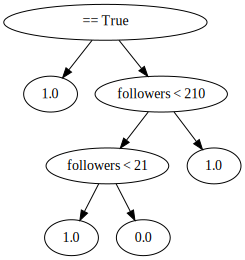

In [28]:
# 평가 기준(criterion)을 정합니다.
# 크게 Classification 문제에서는 evaluate_gini_impurity를,
# Regression 문제에서는 evaluate_mse를 사용하면 됩니다.
criterion_formula = evaluate_gini_impurity
# criterion_formula = evaluate_mse

# Decision Tree의 세부 설정(이하 Hyperparameter)를 세팅합니다. 크게
# 1) 나무의 깊이(max_depth),
# 2) 가지를 치는 최소한의 데이터셋(min_samples_split), 
# 3) 트리의 잎(leaf)에 존재할 수 있는 최소한의 데이터셋(min_samples_leaf)
# 이렇게 세 가지를 세팅합니다.
max_depth = None
min_samples_split = 2
min_samples_leaf = 1

# 트리의 노드(node)를 만드는 함수를 정의합니다.
def make_node(data, condition_list, label_name, current_depth):
    # 먼저 해당 노드가 잎(leaf)인지 아닌지를 구분하는 조건을 정의합니다.
    # 잎이 되지 않을 조건은 다음과 같습니다.
    # 1) 아직 가지를 칠 수 있는 조건(condition)이 남아있고
    condition_exists = (len(condition_list) != 0)
    
    # 2) 가지를 칠 수 있을 만한 최소한의 데이터셋의 갯수가 남아있으며,
    sample_exists = (len(data) >= min_samples_split)
    
    # 3) 트리의 최대 깊이(max_depth)를 지정하지 않았거나,
    #    현재 트리의 깊이(depth)가 지정한 트리의 최대 깊이보다 낮을 경우.
    not_leaf = (max_depth == None) or (current_depth < max_depth)

    # 위 세 가지 조건에 해당하는 경우에는 잎(leaf)이 아니라고 간주하고 가지를 칠 수 있습니다.
    if condition_exists and sample_exists and not_leaf:
        # 현재 데이터셋의 criterion(ex: gini impurity, mse, etc)을 구합니다.
        before_criterion_score = criterion_formula(data, label_name)
        
        # 주어진 조건(condition) 중에서 가장 좋은 조건을 구하고,
        # 그 조건에 관련된 정보(score, description, etc)를 모두 가져옵니다.
        after_criterion_score, description, condition, left_data, right_data = \
            find_best_condition(data, condition_list, label_name, criterion_formula)

        # 여기서 다시 한 번 잎(leaf)인지 아닌지를 구분하는 조건을 구합니다. 가지를 칠 수 있는 조건은 다음과 같습니다.
        # 1) 현재 criterion score보다 새로운 조건의 평균 criterion score가 낮을 경우
        criterion_score_decreased = (after_criterion_score < before_criterion_score)
        
        # 2) 조건(condition)이 참일 경우의 데이터와 거짓일 경우의 데이터 모두 일정 지정한 최소한의 갯수보다 많을 경우.
        enough_samples = (len(left_data) >= min_samples_leaf and len(right_data) >= min_samples_leaf)
    
        # 위의 두 가지 조건에 해당하는 경우에는 가지를 칠 수 있습니다.
        if criterion_score_decreased and enough_samples:
            # 현재 node의 정보를 저장합니다. (잎이 아니기 때문에 leaf를 False로 지정합니다.)
            node = {'leaf': False, 'condition': condition, 'description': description}

            # 이번에 사용한 조건은 다음에 사용하지 않기 위해 condition_list에서 삭제합니다.
            del condition_list[description]

            # Decision Tree의 가지를 칩니다. 왼쪽 가지와 오른쪽 가지 모두 치는데,
            # 왼쪽 가지는 조건의 참(True)일 경우의 데이터(left_data)
            # 오른쪽 가지는 조건의 거딧(False)일 경우의 데이터(right_data)를 집어넣습니다.
            # 여기서 좌측 가지의 조건과 우측 가지의 조건이 충돌하지 않게 하기 위해,
            # 현재 보유한 조건의 원본이 아닌 사본을 .copy()를 통해 집어넣습니다.
            # 그리고 트리의 깊이(depth)에 +1을 해줌으로서 깊이가 하나 더 들어갔다고 간주합니다.
            node['left'] = make_node(left_data, condition_list.copy(), label_name, current_depth + 1)
            node['right'] = make_node(right_data, condition_list.copy(), label_name, current_depth + 1)

            # 가지를 친 결과물에 해당하는 노드(node)를 반환합니다.
            return node

    # 만일 가지를 칠 수 없는 상황이라면 잎(leaf)이라고 간주할 수 있습니다.
    # 이 경우에는 현재 잎에서의 label의 평균치(probability)를 구하고
    probability = data[label_name].mean()
    
    # 이 평균치(probability)를 노드에 할당합니다.
    # (현재 노드는 잎이기 때문에 leaf를 True로 지정합니다)
    node = {'leaf': True, 'probability': probability}
    
    # 이 노드(node)를 반환합니다.
    return node

# 주어진 데이터의 feature, label를 활용해 Decision Tree를 생성하는 함수를 정의합니다.
def make_tree(data, feature_names, label_name):
    # 일단 주어진 feature들로 이론상으로 만들 수 있는 모든 조건(condition)을 만듭니다.
    # 이를 condition_list이라는 이름의 변수에 저장합니다.
    condition_list = make_condition_list(data, feature_names)

    # 주어진 조건과 label, 그리고 데이터를 바탕으로 Decision Tree를 생성합니다.
    # 트리의 맨 위(root)를 첫 번째 노드(node)라고 가정하며, 처음 만들 때의 트리의 깊이(depth)는 0으로 간주합니다.
    # 이 결과를 tree라는 이름의 변수에 할당합니다.
    tree = make_node(data, condition_list, label_name, current_depth = 0)

    # 해당 Decision Tree를 반환합니다.
    return tree

# 데이터와 feature, label를 활용해 Decision Tree를 생성합니다.
# 이 결과를 tree라는 이름의 변수에 할당합니다.
tree = make_tree(data, feature_names, label_name)

# 이 tree를 graphviz를 활용해 출력합니다.
display_tree(tree)

### Prediction

Decision Tree가 만들어졌으면, 만들어진 tree를 활용해서 결과를 예측할 수 있습니다. 예측은 ```predict_tree```라는 함수를 통해 할 수 있습니다.

In [29]:
# 주어진 데이터와 트리로 결과를 예측(predict)합니다.
# 이 결과를 predictions 이라는 이름의 변수에 할당합니다.
predictions = predict_tree(data, tree)

# 현재 데이터셋을 복사(copy)한 뒤 result라는 이름의 변수에 할당합니다.
result = data.copy()

# 이 result라는 변수에 할당한 DataFrame에 방금 예측할 결과를 새로운 컬럼으로 추가합니다.
result[f"{label_name}(predict)"] = predictions

# result를 화면에 출력합니다.
result

,패션스타그램,데일리룩,우산,followers,like,like(predict)
이름,,,,,,
Kang,False,True,False,10,True,1.0
Kim,False,False,False,21,False,0.0
Choi,True,False,False,80,True,1.0
Park,False,False,False,210,True,1.0
Yoon,False,False,False,101,False,0.0
Lee,True,False,False,72,True,1.0


## Implement a Random Forest

위의 코드를 통해 Decision Tree를 구현할 수 있다면, 여기에 몇 가지 기능만 추가하면 바로 Random Forest를 구현할 수 있습니다. Random Forest를 구현하는 방식은 다음과 같습니다.

1. Bagging(내지는 Bootstrap aggregating)를 구현하여 전체 데이터에서 Random Subset를 구합니다. (```bootstrap```)
2. 이 Random Subset에서 Decision Tree를 만드는 작업을 반복합니다. (```make_forest```)
3. 반복해서 만든 forest로 데이터에서 정답을 예측합니다. (```predict_forest```)

### Boostrap

가장 먼저 구현할 기능은 Boostrap입니다. Boostrap은 전체 데이터에서 random subset을 추출하는 작업을 하는데, random subset은 원본 데이터와 갯수는 동일하지만 중복을 허용한다는 차이점이 있습니다. (이를 전문용어로 [복원 추출](https://zetawiki.com/wiki/%EB%B3%B5%EC%9B%90%EC%B6%94%EC%B6%9C,_%EB%B9%84%EB%B3%B5%EC%9B%90%EC%B6%94%EC%B6%9C)이라고 합니다.) 이렇게 하면 일정 부분 중복이 되고, 또 일정 부분 데이터가 누락이 되는 효과가 있습니다. 이렇게 random subset을 반복하면서 Decision Tree를 만들면 미묘하게 다른 Tree를 여러 개 생성할 수 있습니다.

여기에 더불어, 데이터 뿐만 아니라 feature들도 랜덤하게 누락시킬 수 있습니다. 이를 조정하는 hyperparameter를 max_features라고 합니다. max_features에는 보통 실수형 값이 들어가며, 0.1이 들어갈 경우 "전체 features에서 10%만 랜덤하게 추출한다.", 0.7이 들어갈 경우 "전체 features에서 70%만 랜덤하게 추출한다."라고 가정합니다. (이렇게 하면 마찬가지로 성능이 좋아집니다.)

이 정보를 바탕으로 전체 데이터에서 random subset을 추출하는 ```bootstrap``` 기능을 구현해보겠습니다.

In [2]:
# Write your code here!

### Make Forest

Boostrap을 구현하였다면 이를 활용해 Random Forest를 만드는 건 간단합니다. 먼저 1) 원본 데이터를 가져온 뒤, 2) 주어진 n_estimators만큼 Boostrap 실행 -> make_tree로 Decision Tree를 만드는것을 반복하면 됩니다. 코드는 다음과 같습니다.

In [1]:
# Write your code here!

### Predict Forest

Random Forest를 생성한 것과 마찬가지로, Random Forest를 활용해 정답을 예측하는 것도 간단합니다. 그저 주어진 Decision Tree마다 각각 예측을 한 뒤 그 결과의 평균만 내면 됩니다.

In [34]:
# Write your code here!